In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3


In [12]:
# taken from Peter and Lynne's original notebooks
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# get just the first year of observations

In [13]:
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

In [14]:
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    year1 = df[df["night"]<366]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()

In [15]:
nside = 256
# nside = 64
# nside = 32
s = maf.HealpixSlicer(nside=nside)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


In [16]:
# from lynne's notebook, counts the number of visits that have templates
# assuming they are made as soon as enough images are available

In [17]:
# Metric in development

class TemplateTime(maf.BaseMetric):
    """Find the time at which we expect to hit incremental template availability.
    
    Note that there are some complications to real template generation that make this an 
    approximation and not an exact answer -- one aspect is that templates are generated in 
    `patches` and not per pixel. However, it may be possible to generate parts of these patches
    at about 5arcsecond scales, which implies running with a healpix slicer at nside=512 or 1024. 
    
    Parameters
    ----------
    n_visits : `int`, opt
        Number of qualified visits required for incremental template generation. 
        Default 3. 
    seeing_range : `float`, opt
        Range of seeing to allow in the qualified images. 
    m5_range : `float`, opt
        Range of m5 values to allow in the qualified images. Stand in for `weight` in template.
    seeingCol : `str`, opt
        Name of the seeing column to use.
    m5Col : `str`, opt
        Name of the five sigma depth columns.
    nightCol : `str`, opt
        Name of the column describing the night of the visit.
    """
    
    def __init__(self, n_visits=3, seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 nightCol = 'night', **kwargs):
        self.n_visits = n_visits
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.nightCol = nightCol
        if 'metricName' in kwargs:
            self.metricName = kwargs['metricName']
            del kwargs['metricName']
        else:
            self.metricName = 'TemplateTime'
        super().__init__(col=[self.seeingCol, self.m5Col, self.nightCol], 
                         metricName=self.metricName, units="days", **kwargs)

    def run(self, dataSlice, slicePoint=None):
        # Bail if not enough visits at all
        if len(dataSlice) < self.n_visits:
            return self.badval
        
        # Check that the visits are sorted in night
        dataSlice.sort(order=self.nightCol)
        
        # Find the best seeing in the first few images
        bench_seeing = np.min(dataSlice[self.seeingCol][0:self.n_visits+1])
        bench_m5 = np.max(dataSlice[self.m5Col][0:self.n_visits+1])
        
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False)
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)

        both = np.where(seeing_ok & m5_ok)[0]
        if len(both) < self.n_visits:
            return self.badval
            
        idx_template = both[self.n_visits - 1]
        
        n_template = dataSlice[self.nightCol][idx_template]
        d_n = n_template - dataSlice[self.nightCol][0]

        return [n_template, d_n, idx_template + 1]
    
    def reduceNight(self, metricVal):
        return metricVal[0]
    
    def reduceDeltaNight(self, metricVal):
        return metricVal[1]
    
    def reduceNVis(self, metricVal):
        return metricVal[2]

/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/metrics/baseMetric.py:37: UserWarning: Redefining metric __main__.TemplateTime! (there are >1 metrics with the same name)
  warnings.warn(


In [18]:
opsim_fname = year1_fname
opsim_fname

'first_year_baseline_v3.0_10yrs.db'

In [19]:
opsdb = maf.OpsimDatabase(opsim_fname)
runName = os.path.split(opsdb)[-1].replace('.db', '')

In [20]:
bdict = {}
for f in 'ugrizy':
    m = TemplateTime(metricName=f'Template {f}')
    constraint = f'filter == "{f}"'
    bdict[f] = maf.MetricBundle(m, s, constraint, runName=runName)
    
g = maf.MetricBundleGroup(bdict, opsdb, 'temp')
g.runAll()

Querying table None with constraint filter == "u" for columns ['night', 'fieldDec', 'fieldRA', 'seeingFwhmEff', 'rotSkyPos', 'fiveSigmaDepth']
Found 10136 visits
Running:  ['u']


KeyboardInterrupt: 

In [ ]:
bdict.keys()


In [ ]:

ph = maf.PlotHandler(outDir='temp', thumbnail=False)

for f in 'ugrizy':
    k = f'Template {f}_DeltaNight'
    ph.setMetricBundles([bdict[k]])
    plotDict = {'figsize': (8, 6), 'colorMin': 0, 'colorMax': 60}
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts=plotDict)

In [ ]:

nights = np.arange(0, 3650, 1)
pixarea = hp.nside2pixarea(nside, degrees=True)
area_over_time = {}
area_since_first = {}
for f in 'ugrizy':
    k = f'Template {f}_Night'
    counts, bins = np.histogram(bdict[k].metricValues.compressed(), bins=nights)
    area_over_time[f] = counts.cumsum() * pixarea 
    k = f'Template {f}_DeltaNight'
    counts, bins = np.histogram(bdict[k].metricValues.compressed(), bins=nights)
    area_since_first[f] = counts.cumsum() * pixarea 

In [ ]:

# Count up area in footprint, for reference (varies by filter)
footprint_area = {}
for f in 'ugrizy':
    k = f'Template {f}_Night'
    footprint_area[f] = len(bdict[k].metricValues.compressed()) * pixarea

In [ ]:

plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    plt.plot(nights[:-1], area_over_time[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlabel('Night in survey', fontsize='large')
plt.ylabel('Area with possible template', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
plt.axhline(footprint_area['u'], color='b', linestyle=':', alpha=0.5)
plt.axhline(footprint_area['r'], color='g', linestyle=':', alpha=0.5)
print(footprint_area)

In [ ]:

plt.figure(figsize=(8, 6))
for f in 'ugrizy':
    # Show percent of footprint 
    plt.plot(nights[:-1], area_since_first[f] / footprint_area[f], label=f)
plt.legend()
plt.xlim(0, 365*2)
plt.xlim(0, 90)
plt.xlabel(r'$\Delta$ night since first visit', fontsize='large')
#plt.ylabel('Area with possible template', fontsize='large')
plt.ylabel('Percent of footprint', fontsize='large')
plt.axvline(365, color='k', linestyle=':')
print(footprint_area)

In [ ]:
# To do: make this figure for each filter, where the different lines are the different cadence simulations

# Remove visits without templates using Peter's code

Add Lynne's requirements on image quality when counting number of available images to generate template with.

Peter's code assumes that a template will be generated once, on a given night.

In [21]:
# new base class. We might consider moving this into BaseMetric, or maybe doing this in the slicer instead.
class BaseTemplateMetric(maf.metrics.BaseMetric):
    """Make a new base class that will filter out observation from before we have templates available
    """
    def __init__(self,
                col=None,
                n_vists_for_template=3., # note that this is float
                night_template_min=182,
                mjdCol='observationStartMJD',
                nightCol='night',
                filterCol='filter',
                 seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 **kwargs):
        if col is None:
            col = []
        else:
            col = [col]
        col += [mjdCol, nightCol, filterCol]
        super().__init__(col=col, **kwargs)
        self.n_vists_for_template = n_vists_for_template
        self.night_template_min = night_template_min
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol
        
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        
        print(self.seeing_ratio,self.m5_range)
        
    def _remove_no_template_visits(self, dataSlice):
        
#         # Bail if not enough visits at all
#         if len(dataSlice) < self.n_vists_for_template:
#             print("return bad")
#             return self.badval
        
        dataSlice.sort(order=self.mjdCol)
        
        # add Lynne's seeing requirements
                # Find the best seeing in the first few images
        n_visits = int(self.n_vists_for_template)
        
        bench_seeing = np.min(dataSlice[self.seeingCol][0:n_visits+1])
        bench_m5 = np.max(dataSlice[self.m5Col][0:n_visits+1])
        
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False)
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)
        
#         both = np.where(seeing_ok & m5_ok)[0]
#         print(both)
#         print(seeing_ok & m5_ok)

#         if len(both) < self.n_vists_for_template:
#             print("return bad")
#             return self.badval #RETURN EMPTY DATASLICE?
        
        # limit available template ids using "both"
        
        has_template_indx = np.ones(dataSlice.size, dtype=bool)
        has_template_indx[~(seeing_ok & m5_ok)] = False
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)[0]
#             print(infilt)
            max_indx = np.min([self.n_vists_for_template, np.size(infilt)]).astype(int)
            # The first n visits in a filter can't have a template
            has_template_indx[infilt][0:max_indx] = False
        # Can't have a template before the template construction time
        has_template_indx[np.where(dataSlice[self.nightCol] < self.night_template_min)] = False
        # There is an edge case here were a few spots on the sky might not have 3 visits by 
        # self.night_template_min, and they technically wouldn't get templates generated until
        # the next data release. But I don't want to have multiple data release dates in the kwargs now.
        
#         print(has_template_indx)
#         print(len(dataSlice[has_template_indx]))
        
        return dataSlice[has_template_indx]
        
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return

In [45]:
# new base class. We might consider moving this into BaseMetric, or maybe doing this in the slicer instead.
class BaseTemplateMetric(maf.metrics.BaseMetric):
    """Make a new base class that will filter out observation from before we have templates available
    """
    def __init__(self,
                col=None,
                n_visits_for_template=3., # note that this is float
                night_template_min=182,
                mjdCol='observationStartMJD',
                nightCol='night',
                filterCol='filter',
                 seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 **kwargs):
        if col is None:
            col = []
        else:
            col = [col]
        col += [mjdCol, nightCol, filterCol]
        super().__init__(col=col, **kwargs)
        self.n_vists_for_template = n_vists_for_template
        self.night_template_min = night_template_min
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol
        
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        
#         print(self.seeing_ratio,self.m5_range)
        
    def _remove_no_template_visits(self, dataSlice):
        
        dataSlice.sort(order=self.mjdCol)
        
        # add Lynne's seeing requirements
        # Find the best seeing in the first few images
        n_visits = int(self.n_visits_for_template)
        
        bench_seeing = np.min(dataSlice[self.seeingCol][0:n_visits+1])
        bench_m5 = np.max(dataSlice[self.m5Col][0:n_visits+1])
        
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False)
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)
        
        # template images must have been taken before the generation date
        template_time = np.where(dataSlice[self.nightCol] < self.night_template_min,
                        True, False)
        # science images can only be counted after the generation date
        image_time = np.where(dataSlice[self.nightCol] > self.night_template_min,
                        True, False)
        # should use a greater than sign for nights here? Or allow leeway for template generation time?
        
        # use masks to remove images not suitable for templates/science
        # everything starts as true and is switched to false if required
        has_template_indx = np.ones(dataSlice.size, dtype=bool)
        template_img_indx = np.ones(dataSlice.size, dtype=bool)
        # define list of images that are suitable for generating templates
        template_img_indx[~(seeing_ok & m5_ok & template_time)] = False
        
        # define list of possible science images, can't have a template before the template construction time
        has_template_indx[~(image_time)] = False
        
#         print(self.night_template_min,len(dataSlice),sum(template_img_indx),sum(has_template_indx))
        
        # look at each dataslice by filter, template images must be in the same filter
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)[0]
#             max_indx = np.min([self.n_vists_for_template, np.size(infilt)]).astype(int)
#             # The first n visits in a filter can't have a template
#             has_template_indx[infilt][0:max_indx] = False
            
            # check if there are is a sufficent number of templates
            # if not, no science images can be counted until next template time
            if sum(template_img_indx[infilt])<n_visits:
                has_template_indx[infilt] = False
#             else:
#                 has_template_indx[infilt & image_time] = True
        
#         print(sum(has_template_indx))

        return dataSlice[has_template_indx]
        
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return

In [46]:

# OK, now let's write a function that takes a bunch of observations in, 
# then cuts out ones that probably don't have template images

# Class that will return all the id's that we think have templates generated
class HasTemplateIndx(BaseTemplateMetric):
    """Return the obIds that probably have templates
    """
    def __init__(self, col='observationId', metricDtype="object", **kwargs):
        super().__init__(col=col, metricDtype=metricDtype, **kwargs)
        self.idCol = col
    def run(self, dataSlice, slicePoint=None):
        dataSlice = self._remove_no_template_visits(dataSlice)
        return dataSlice[self.idCol]

In [47]:

def remove_no_templates(data_in, nside=32, id_col='observationId', night_template_min = 182, **kwargs):
    """Remove visits that probably have no templates
    """
    slicer = maf.slicers.HealpixSlicer(nside=nside, verbose=False)
    metric = HasTemplateIndx(night_template_min = night_template_min, **kwargs)
    print("night_template_min = {}".format(metric.night_template_min))
    sql=None
    bundle = maf.MetricBundle(metric, slicer, sql)
    mbg = maf.MetricBundleGroup([bundle], None, saveEarly=False,
                                verbose=False)
    mbg.runCurrent(None, simData=data_in)
    all_vals = np.concatenate(bundle.metricValues.data[~bundle.metricValues.mask])
    valid_ids = np.unique(all_vals)
    indx = np.in1d(data_in[id_col], valid_ids)
    result = data_in[indx]
    return result

In [34]:
night_template_min = 1
x = HasTemplateIndx(night_template_min=1)
x.__dict__.keys()

dict_keys(['colNameArr', 'maps', 'badval', 'name', 'reduceFuncs', 'reduceOrder', 'metricDtype', 'units', 'comment', 'shape', 'n_vists_for_template', 'night_template_min', 'mjdCol', 'nightCol', 'filterCol', 'seeingCol', 'm5Col', 'seeing_ratio', 'm5_range', 'idCol'])

In [35]:
x.night_template_min, x.mjdCol

(1, 'observationStartMJD')

In [36]:
opsdb

'first_year_baseline_v3.0_10yrs.db'

In [37]:
# let's load up some data
data = maf.getSimData(opsdb, None, None, full_sql_query='select * from observations where night < 365;')

In [38]:
pd.DataFrame(data)[['seeingFwhmEff','fiveSigmaDepth']]

,seeingFwhmEff,fiveSigmaDepth
0,0.694106,22.546480
1,0.699498,22.532127
2,0.694568,22.546281
3,2.363392,23.128326
4,2.418207,23.075882
...,...,...
216115,1.465921,22.575541
216116,1.459859,22.589142
216117,1.507974,22.458614
216118,1.516937,22.447880


In [43]:
# set limits high, should get same results as Peter's default notebook
# where there was no quality control on template images
data_w_templates = remove_no_templates(data,seeing_ratio=200., m5_range=5)
data_w_templates.size

night_template_min = 182
182 1 1 0
0
182 3 3 0
0
182 2 2 0
0
182 2 2 0
0
182 2 2 0
0
182 6 6 0
0
182 2 2 0
0
182 2 2 0
0
182 6 6 0
0
182 12 12 0
0
182 9 9 0
0
182 8 8 0
0
182 7 7 0
0
182 5 5 0
0
182 4 4 0
0
182 8 8 0
0
182 8 8 0
0
182 6 6 0
0
182 8 8 0
0
182 2 2 0
0
182 2 2 0
0
182 3 3 0
0
182 2 2 0
0
182 6 6 0
0
182 10 10 0
0
182 10 10 0
0
182 6 6 0
0
182 10 10 0
0
182 16 16 0
0
182 18 18 0
0
182 19 19 0
0
182 17 17 0
0
182 19 19 0
0
182 16 16 0
0
182 16 16 0
0
182 18 18 0
0
182 20 20 0
0
182 20 20 0
0
182 8 8 0
0
182 11 11 0
0
182 6 6 0
0
182 5 5 0
0
182 6 6 0
0
182 2 2 0
0
182 2 2 0
0
182 1 1 0
0
182 9 9 0
0
182 13 13 0
0
182 12 12 0
0
182 10 10 0
0
182 14 14 0
0
182 14 14 0
0
182 20 20 0
0
182 21 21 0
0
182 15 15 0
0
182 20 20 0
0
182 21 21 0
0
182 26 26 0
0
182 20 20 0
0
182 18 18 0
0
182 24 24 0
0
182 22 22 0
0
182 20 20 0
0
182 18 18 0
0
182 14 14 0
0
182 14 14 0
0
182 20 20 0
0
182 10 10 0
0
182 11 11 0
0
182 5 5 0
0
182 3 3 0
0
182 1 1 0
0
182 2 2 0
0
182 6 6 0
0
182 8 8 0
0
1

182 32 24 8
8
182 28 21 7
7
182 40 24 16
16
182 50 37 13
13
182 62 56 6
6
182 48 45 3
3
182 58 47 11
11
182 68 56 12
12
182 62 50 12
12
182 67 49 18
18
182 61 44 17
17
182 67 54 13
13
182 69 55 14
14
182 75 55 20
19
182 68 52 16
16
182 62 37 25
22
182 47 35 12
11
182 55 42 13
11
182 49 44 5
4
182 58 42 16
14
182 62 35 27
24
182 59 35 24
20
182 57 37 20
17
182 65 36 29
25
182 62 32 30
26
182 64 36 28
24
182 60 33 27
24
182 46 25 21
20
182 36 19 17
14
182 50 24 26
21
182 52 32 20
15
182 87 39 48
40
182 85 41 44
35
182 87 42 45
37
182 89 43 46
39
182 81 41 40
35
182 64 33 31
24
182 37 13 24
6
182 37 10 27
5
182 46 18 28
19
182 44 17 27
17
182 47 17 30
8
182 44 18 26
15
182 37 11 26
11
182 38 10 28
17
182 28 11 17
3
182 31 9 22
4
182 40 13 27
20
182 43 13 30
19
182 42 8 34
11
182 36 10 26
15
182 43 9 34
3
182 33 3 30
0
182 39 2 37
0
182 35 6 29
5
182 47 3 44
8
182 47 7 40
7
182 45 5 40
7
182 44 4 40
7
182 49 3 46
0
182 41 4 37
0
182 39 2 37
0
182 35 0 35
0
182 35 0 35
0
182 32 2 30
0
182 2

182 76 8 67
12
182 73 5 68
11
182 68 5 63
14
182 81 4 77
14
182 69 4 64
14
182 78 5 72
15
182 77 4 72
14
182 73 2 70
0
182 68 2 65
0
182 39 4 35
9
182 31 2 29
0
182 30 2 28
0
182 30 2 28
0
182 58 4 54
7
182 65 2 63
0
182 66 1 65
0
182 44 0 44
0
182 29 0 29
0
182 21 0 21
0
182 11 8 3
1
182 10 6 4
0
182 15 10 5
4
182 15 10 5
4
182 21 16 5
5
182 16 14 2
2
182 15 15 0
0
182 19 15 4
4
182 20 16 4
4
182 16 12 4
3
182 21 19 2
2
182 20 20 0
0
182 18 18 0
0
182 16 16 0
0
182 12 12 0
0
182 19 19 0
0
182 20 20 0
0
182 19 19 0
0
182 16 16 0
0
182 26 23 3
3
182 21 19 2
2
182 27 23 4
4
182 25 25 0
0
182 26 26 0
0
182 25 25 0
0
182 20 20 0
0
182 25 25 0
0
182 29 26 3
3
182 29 23 6
6
182 26 22 4
4
182 27 20 7
7
182 34 24 10
10
182 30 22 8
8
182 32 18 14
14
182 30 23 7
7
182 27 23 4
4
182 28 22 6
6
182 24 23 1
1
182 84 78 6
6
182 106 88 18
18
182 102 87 15
15
182 112 97 15
15
182 97 85 12
12
182 89 73 16
16
182 101 88 13
13
182 92 77 15
15
182 98 85 13
13
182 102 85 17
17
182 100 82 18
18
182 89 62 27


182 72 38 34
34
182 64 37 27
27
182 71 46 25
25
182 77 46 31
31
182 67 45 22
22
182 70 47 23
23
182 76 50 26
26
182 81 59 22
22
182 78 59 19
19
182 85 64 21
21
182 77 64 13
13
182 81 66 15
15
182 70 60 10
10
182 75 60 15
15
182 82 69 13
13
182 72 63 9
9
182 69 63 6
6
182 56 51 5
5
182 38 33 5
1
182 32 32 0
0
182 74 70 4
4
182 84 76 8
8
182 89 77 12
12
182 80 69 11
11
182 89 81 8
8
182 84 80 4
4
182 32 32 0
0
182 25 21 4
4
182 33 25 8
8
182 27 23 4
4
182 25 21 4
4
182 29 26 3
3
182 21 18 3
3
182 27 19 8
8
182 45 39 6
6
182 95 81 14
14
182 105 90 15
15
182 93 78 15
15
182 104 85 19
19
182 108 88 20
20
182 101 74 27
27
182 83 67 16
16
182 104 78 26
26
182 100 81 19
19
182 118 90 28
28
182 101 71 30
30
182 118 83 35
35
182 109 79 30
30
182 99 71 28
28
182 87 66 21
19
182 801 615 186
186
182 103 77 26
26
182 91 60 31
29
182 85 48 37
32
182 95 69 26
26
182 84 51 33
30
182 95 70 25
23
182 99 62 37
33
182 93 53 40
36
182 92 55 37
31
182 95 55 40
37
182 89 51 38
31
182 85 44 41
32
182 91 44 47


182 92 53 39
35
182 87 52 35
30
182 83 50 33
30
182 80 46 34
32
182 84 52 32
25
182 90 46 44
35
182 84 42 42
33
182 78 40 38
31
182 87 33 54
44
182 82 30 50
40
182 86 29 57
45
182 81 24 55
44
182 77 23 52
43
182 75 19 54
30
182 85 24 61
28
182 85 22 61
50
182 81 27 54
41
182 83 20 61
53
182 87 27 56
51
182 80 21 58
50
182 83 15 68
39
182 88 19 69
37
182 94 18 76
47
182 84 22 62
51
182 78 19 59
34
182 55 15 40
16
182 59 13 46
23
182 43 21 22
17
182 51 25 26
15
182 43 13 30
19
182 29 4 25
1
182 38 6 32
9
182 26 6 20
4
182 28 10 18
3
182 41 3 38
9
182 57 8 49
12
182 52 8 44
10
182 50 9 41
11
182 33 4 29
0
182 33 6 27
7
182 37 9 28
12
182 28 4 24
0
182 20 6 14
0
182 87 14 73
14
182 88 17 71
31
182 68 14 54
45
182 76 12 64
22
182 82 22 60
55
182 75 22 53
47
182 67 20 47
34
182 84 34 50
50
182 76 26 50
44
182 92 29 63
63
182 83 29 54
54
182 81 33 48
48
182 87 34 53
53
182 94 37 57
57
182 75 28 47
47
182 83 43 40
40
182 71 31 40
40
182 72 34 38
37
182 77 43 34
34
182 83 46 37
37
182 80 41 39


182 37 9 28
12
182 43 10 33
14
182 43 15 28
17
182 47 17 30
19
182 43 11 32
15
182 44 15 29
13
182 33 6 27
7
182 39 10 29
6
182 75 8 67
17
182 80 9 71
22
182 80 11 69
27
182 80 9 71
29
182 76 8 68
17
182 85 6 79
23
182 75 11 64
18
182 57 10 47
18
182 28 5 23
7
182 50 10 40
22
182 92 17 75
68
182 80 12 68
31
182 84 18 66
47
182 83 18 65
58
182 84 28 56
49
182 72 23 49
49
182 83 25 58
52
182 87 28 59
51
182 92 43 49
49
182 85 39 46
46
182 89 40 49
49
182 78 25 53
49
182 76 36 40
40
182 83 39 44
44
182 83 38 45
45
182 80 37 43
39
182 73 32 41
41
182 88 41 47
47
182 73 33 40
40
182 77 41 36
36
182 80 46 34
34
182 71 46 25
25
182 91 59 32
32
182 88 63 25
25
182 85 49 36
36
182 80 45 35
35
182 78 48 30
30
182 68 43 25
25
182 94 55 39
39
182 69 51 18
18
182 86 59 27
27
182 86 70 16
16
182 81 56 25
25
182 87 59 28
28
182 77 62 15
15
182 78 65 13
13
182 82 70 12
12
182 76 65 11
11
182 82 68 14
14
182 83 70 13
13
182 74 64 10
10
182 72 66 6
6
182 76 72 4
4
182 75 73 2
2
182 78 77 1
1
182 82 77 5

182 85 63 22
22
182 81 55 26
26
182 77 59 18
18
182 85 65 20
20
182 88 63 25
25
182 71 57 14
14
182 78 67 11
11
182 84 72 12
12
182 75 69 6
6
182 73 68 5
5
182 72 69 3
3
182 64 62 2
2
182 77 76 1
1
182 75 74 1
1
182 84 83 1
1
182 87 86 1
1
182 85 82 3
3
182 82 78 4
4
182 94 92 2
2
182 99 99 0
0
182 90 88 2
2
182 94 92 2
2
182 59 57 2
2
182 48 48 0
0
182 35 35 0
0
182 33 33 0
0
182 36 36 0
0
182 39 33 6
6
182 40 34 6
6
182 43 38 5
5
182 41 37 4
4
182 94 73 21
21
182 119 92 27
27
182 112 84 28
28
182 119 97 22
22
182 111 77 34
34
182 105 73 32
31
182 110 76 34
32
182 108 79 29
29
182 99 73 26
23
182 109 78 31
31
182 112 79 33
33
182 106 78 28
28
182 105 72 33
29
182 109 78 31
28
182 104 75 29
24
182 99 66 33
30
182 90 64 26
21
182 97 66 31
27
182 97 52 45
36
182 93 59 34
31
182 92 51 41
37
182 97 67 30
25
182 93 53 40
34
182 91 59 32
29
182 95 55 40
35
182 99 51 48
39
182 93 54 39
31
182 81 42 39
29
182 75 34 41
33
182 95 45 50
38
182 85 37 48
39
182 89 39 48
39
182 78 39 37
27
182 86 27

182 73 34 39
37
182 79 46 33
32
182 78 45 33
33
182 93 50 43
43
182 78 49 29
29
182 78 53 25
25
182 86 57 29
29
182 90 60 30
30
182 91 61 30
30
182 74 54 20
20
182 74 55 19
19
182 93 69 24
24
182 80 53 27
27
182 86 61 25
25
182 77 54 23
23
182 71 51 20
20
182 69 52 17
17
182 77 60 17
17
182 82 64 18
18
182 69 55 14
14
182 89 75 14
14
182 75 64 11
11
182 74 69 5
5
182 71 64 7
7
182 75 71 4
4
182 78 76 2
2
182 81 79 2
2
182 89 88 1
1
182 87 87 0
0
182 83 83 0
0
182 90 90 0
0
182 88 88 0
0
182 89 89 0
0
182 87 87 0
0
182 105 103 2
2
182 102 100 2
2
182 92 90 2
2
182 88 84 4
4
182 107 100 7
7
182 108 97 11
11
182 62 58 4
4
182 40 36 4
4
182 30 26 4
3
182 42 40 2
2
182 38 36 2
2
182 47 41 6
6
182 66 58 8
8
182 91 67 24
24
182 112 92 20
20
182 110 87 23
23
182 112 86 26
26
182 110 83 27
27
182 132 101 31
31
182 121 85 36
36
182 105 79 26
25
182 98 79 19
19
182 91 68 23
23
182 99 73 26
26
182 96 64 32
27
182 106 74 32
26
182 105 68 37
32
182 91 56 35
26
182 89 56 33
28
182 95 58 37
32
182 88 

182 79 68 11
11
182 90 80 10
10
182 314 231 83
83
182 76 73 3
3
182 65 64 1
1
182 74 74 0
0
182 88 88 0
0
182 79 79 0
0
182 84 84 0
0
182 77 77 0
0
182 100 100 0
0
182 86 84 2
2
182 103 101 2
2
182 92 90 2
2
182 106 104 2
2
182 94 92 2
2
182 97 97 0
0
182 112 110 2
2
182 99 97 2
2
182 104 97 7
7
182 95 86 9
9
182 51 47 4
4
182 43 39 4
4
182 39 33 6
6
182 38 34 4
4
182 41 30 11
11
182 49 44 5
5
182 87 62 25
25
182 102 74 28
28
182 102 79 23
23
182 106 83 21
21
182 104 75 29
29
182 105 80 23
22
182 111 82 25
25
182 101 78 21
21
182 87 68 19
19
182 111 82 29
26
182 101 68 33
29
182 90 66 24
21
182 92 59 33
28
182 102 69 33
28
182 92 55 37
33
182 105 61 44
38
182 86 51 35
32
182 92 60 32
27
182 87 47 40
27
182 92 54 38
30
182 78 44 34
27
182 86 52 34
27
182 89 48 41
34
182 96 51 45
37
182 93 51 42
36
182 88 40 48
40
182 87 48 39
32
182 91 43 46
38
182 97 39 56
44
182 77 30 45
37
182 85 34 49
40
182 98 28 70
60
182 87 26 60
52
182 89 30 59
48
182 93 29 62
51
182 84 28 51
39
182 81 18 62
42


182 74 53 21
21
182 72 52 20
20
182 71 58 13
13
182 78 65 13
13
182 74 66 8
8
182 75 66 9
9
182 68 66 2
2
182 82 76 6
6
182 64 63 1
1
182 78 77 1
1
182 79 77 2
2
182 73 73 0
0
182 69 69 0
0
182 77 77 0
0
182 88 88 0
0
182 100 100 0
0
182 91 88 3
3
182 87 85 2
2
182 91 87 4
4
182 108 105 3
3
182 94 89 5
5
182 90 88 2
2
182 100 93 7
7
182 93 91 2
2
182 101 97 4
4
182 106 95 11
11
182 117 105 12
12
182 107 89 18
18
182 103 89 14
14
182 55 51 4
4
182 42 38 4
4
182 42 40 2
2
182 45 39 6
6
182 50 48 2
2
182 50 44 6
6
182 43 36 7
7
182 45 32 11
11
182 44 34 6
6
182 52 38 10
10
182 102 74 26
24
182 104 77 25
23
182 103 77 24
21
182 100 74 25
22
182 89 66 23
21
182 99 72 27
24
182 106 76 30
25
182 96 61 35
31
182 94 52 42
34
182 89 50 39
29
182 92 58 34
29
182 89 51 38
32
182 99 56 43
36
182 80 42 38
32
182 84 48 36
28
182 89 53 36
29
182 91 56 32
31
182 87 51 34
29
182 91 50 38
32
182 85 44 41
32
182 86 42 44
33
182 86 38 46
36
182 81 40 39
32
182 78 44 34
28
182 91 29 58
47
182 93 24 67
56
18

182 58 56 2
2
182 37 35 2
2
182 44 38 6
6
182 45 40 5
5
182 39 37 2
2
182 41 37 4
4
182 36 34 2
2
182 39 31 6
6
182 52 42 8
8
182 47 31 14
13
182 43 31 10
9
182 53 32 19
15
182 68 38 26
24
182 94 60 32
30
182 92 63 28
27
182 93 62 29
27
182 89 58 30
28
182 115 74 41
37
182 101 68 33
28
182 101 69 32
27
182 94 55 39
35
182 85 51 34
27
182 87 54 33
26
182 90 51 33
28
182 103 63 37
30
182 84 49 35
29
182 91 47 44
36
182 94 54 38
34
182 90 57 30
23
182 85 43 39
31
182 94 49 42
33
182 85 41 40
32
182 94 50 42
34
182 84 33 51
43
182 84 29 53
40
182 95 30 62
50
182 92 25 65
54
182 87 22 63
38
182 88 22 64
53
182 90 28 58
47
182 91 28 60
52
182 81 22 59
47
182 82 18 64
40
182 89 18 71
58
182 49 11 38
13
182 40 7 33
9
182 42 8 34
8
182 38 5 33
4
182 32 2 30
0
182 32 5 27
7
182 45 6 39
11
182 75 6 69
0
182 84 8 76
13
182 75 2 73
0
182 67 3 64
0
182 83 7 76
12
182 73 3 70
13
182 76 3 73
18
182 80 3 77
14
182 71 3 68
14
182 78 3 75
15
182 74 3 71
0
182 75 5 70
17
182 82 5 77
16
182 72 5 67
9
182 8

182 93 64 27
24
182 92 61 29
26
182 105 69 32
28
182 91 52 37
32
182 97 57 38
33
182 102 53 45
32
182 86 54 30
26
182 97 49 48
37
182 84 45 39
31
182 96 52 44
34
182 99 51 47
39
182 98 48 48
39
182 80 39 39
30
182 90 42 46
38
182 84 32 50
36
182 95 35 56
40
182 79 30 47
36
182 90 31 57
48
182 87 28 57
49
182 86 27 58
50
182 76 27 44
38
182 75 20 53
47
182 51 16 33
22
182 49 12 37
16
182 35 9 26
4
182 37 5 32
0
182 34 7 27
7
182 30 6 24
4
182 26 2 24
0
182 31 5 26
6
182 76 10 66
21
182 82 10 72
20
182 73 6 67
13
182 69 7 62
10
182 72 9 63
10
182 68 4 64
15
182 80 3 77
15
182 76 5 71
14
182 75 3 72
14
182 65 3 62
7
182 75 2 73
0
182 67 2 65
0
182 81 3 78
0
182 81 7 74
13
182 79 7 72
14
182 78 6 72
16
182 86 9 77
15
182 76 6 70
9
182 83 17 66
39
182 92 14 78
51
182 73 20 53
42
182 82 19 63
53
182 65 26 39
37
182 82 35 47
47
182 79 34 45
45
182 67 31 36
35
182 72 31 41
40
182 75 31 44
39
182 78 36 42
37
182 76 36 40
37
182 82 37 45
45
182 97 54 43
43
182 89 38 51
51
182 79 42 37
37
182 78 

182 78 34 44
44
182 81 41 40
37
182 76 35 41
41
182 84 46 38
38
182 92 48 44
44
182 86 43 43
43
182 82 38 44
44
182 75 47 28
28
182 80 49 31
31
182 91 48 43
43
182 81 51 30
30
182 65 47 18
18
182 79 62 17
17
182 65 49 16
16
182 71 56 15
15
182 69 56 13
13
182 85 71 14
14
182 71 63 8
8
182 73 73 0
0
182 84 80 4
4
182 66 62 4
4
182 73 67 6
6
182 80 77 3
3
182 86 80 6
6
182 78 73 5
5
182 94 87 7
7
182 100 95 5
5
182 87 83 4
4
182 99 93 6
6
182 100 89 11
11
182 106 84 22
22
182 113 95 18
18
182 123 105 18
18
182 105 95 10
10
182 92 71 21
21
182 57 49 8
8
182 42 30 12
11
182 41 31 10
10
182 43 38 5
5
182 47 37 8
7
182 47 33 14
13
182 94 57 33
33
182 113 70 41
41
182 99 58 37
35
182 94 57 36
33
182 91 60 30
28
182 100 62 36
32
182 87 55 31
30
182 87 52 34
24
182 64 42 22
19
182 38 25 11
8
182 42 25 15
10
182 37 20 17
9
182 38 18 20
12
182 45 20 22
13
182 25 15 10
4
182 40 24 13
4
182 35 12 20
5
182 76 30 44
33
182 78 22 53
42
182 82 25 57
46
182 73 15 58
47
182 93 22 71
56
182 86 22 64
51
18

182 85 45 40
40
182 85 50 35
35
182 79 54 25
25
182 69 48 21
21
182 76 58 18
18
182 82 66 16
16
182 75 63 12
12
182 72 69 3
3
182 78 72 6
6
182 88 82 6
6
182 90 84 6
6
182 92 83 7
7
182 101 92 9
9
182 110 93 15
15
182 102 85 17
17
182 85 72 11
11
182 51 48 3
3
182 58 48 10
10
182 61 43 16
16
182 62 43 19
19
182 60 49 11
11
182 45 35 10
10
182 40 27 13
10
182 41 29 10
7
182 40 23 17
8
182 40 28 12
5
182 52 23 27
23
182 65 34 26
16
182 38 14 22
11
182 36 20 15
8
182 40 19 21
17
182 36 11 25
11
182 41 14 24
13
182 48 8 36
6
182 43 11 32
13
182 36 5 31
5
182 52 2 50
0
182 40 2 38
0
182 34 2 32
0
182 36 1 35
0
182 49 3 46
9
182 45 4 41
0
182 45 4 41
11
182 43 9 34
6
182 40 8 32
11
182 48 22 26
24
182 41 20 21
17
182 42 22 20
19
182 53 28 25
25
182 53 29 24
23
182 49 35 14
14
182 71 39 32
32
182 69 38 31
31
182 85 42 43
43
182 73 47 26
26
182 74 60 14
14
182 71 56 15
15
182 79 66 13
13
182 73 62 11
11
182 80 73 7
7
182 85 77 8
8
182 89 81 6
6
182 92 85 7
7
182 107 92 13
13
182 101 85 14
14
1

68823

In [44]:
data_w_templates = remove_no_templates(data,seeing_ratio=200., m5_range=5,night_template_min = 0.)
data_w_templates.size

night_template_min = 0.0
0.0 1 0 1
0
0.0 3 0 3
0
0.0 2 0 2
0
0.0 2 0 2
0
0.0 2 0 2
0
0.0 6 0 6
0
0.0 2 0 2
0
0.0 2 0 2
0
0.0 6 0 6
0
0.0 12 0 12
0
0.0 9 0 9
0
0.0 8 0 8
0
0.0 7 0 7
0
0.0 5 0 5
0
0.0 4 0 4
0
0.0 8 0 8
0
0.0 8 0 8
0
0.0 6 0 6
0
0.0 8 0 8
0
0.0 2 0 2
0
0.0 2 0 2
0
0.0 3 0 3
0
0.0 2 0 2
0
0.0 6 0 6
0
0.0 10 0 10
0
0.0 10 0 10
0
0.0 6 0 6
0
0.0 10 0 10
0
0.0 16 0 16
0
0.0 18 0 18
0
0.0 19 0 19
0
0.0 17 0 17
0
0.0 19 0 19
0
0.0 16 0 16
0
0.0 16 0 16
0
0.0 18 0 18
0
0.0 20 0 20
0
0.0 20 0 20
0
0.0 8 0 8
0
0.0 11 0 11
0
0.0 6 0 6
0
0.0 5 0 5
0
0.0 6 0 6
0
0.0 2 0 2
0
0.0 2 0 2
0
0.0 1 0 1
0
0.0 9 0 9
0
0.0 13 0 13
0
0.0 12 0 12
0
0.0 10 0 10
0
0.0 14 0 14
0
0.0 14 0 14
0
0.0 20 0 20
0
0.0 21 0 21
0
0.0 15 0 15
0
0.0 20 0 20
0
0.0 21 0 21
0
0.0 26 0 26
0
0.0 20 0 20
0
0.0 18 0 18
0
0.0 24 0 24
0
0.0 22 0 22
0
0.0 20 0 20
0
0.0 18 0 18
0
0.0 14 0 14
0
0.0 14 0 14
0
0.0 20 0 20
0
0.0 10 0 10
0
0.0 11 0 11
0
0.0 5 0 5
0
0.0 3 0 3
0
0.0 1 0 1
0
0.0 2 0 2
0
0.0 6 0 6
0
0.0 8 0 8
0
0

0.0 5 0 5
0
0.0 8 0 8
0
0.0 2 0 2
0
0.0 1 0 1
0
0.0 2 0 2
0
0.0 2 0 2
0
0.0 1 0 1
0
0.0 2 0 2
0
0.0 4 0 4
0
0.0 4 0 4
0
0.0 12 0 12
0
0.0 17 0 17
0
0.0 17 0 17
0
0.0 17 0 17
0
0.0 13 0 13
0
0.0 16 0 16
0
0.0 21 0 21
0
0.0 23 0 23
0
0.0 23 0 23
0
0.0 14 0 14
0
0.0 8 0 8
0
0.0 14 0 14
0
0.0 23 0 23
0
0.0 22 0 22
0
0.0 26 0 26
0
0.0 22 0 22
0
0.0 19 0 19
0
0.0 19 0 19
0
0.0 19 0 19
0
0.0 24 0 24
0
0.0 27 0 27
0
0.0 24 0 24
0
0.0 38 0 38
0
0.0 27 0 27
0
0.0 25 0 25
0
0.0 26 0 26
0
0.0 34 0 34
0
0.0 31 0 31
0
0.0 32 0 32
0
0.0 28 0 28
0
0.0 40 0 40
0
0.0 50 0 50
0
0.0 62 0 62
0
0.0 48 0 48
0
0.0 58 0 58
0
0.0 68 0 68
0
0.0 62 0 62
0
0.0 67 0 67
0
0.0 61 0 61
0
0.0 67 0 67
0
0.0 69 0 69
0
0.0 75 0 75
0
0.0 68 0 68
0
0.0 62 0 62
0
0.0 47 0 47
0
0.0 55 0 55
0
0.0 49 0 49
0
0.0 58 0 58
0
0.0 62 0 62
0
0.0 59 0 59
0
0.0 57 0 57
0
0.0 65 0 65
0
0.0 62 0 62
0
0.0 64 0 64
0
0.0 60 0 60
0
0.0 46 0 46
0
0.0 36 0 36
0
0.0 50 0 50
0
0.0 52 0 52
0
0.0 87 0 87
0
0.0 85 0 85
0
0.0 87 0 87
0
0.0 89 0 89
0


0.0 21 0 21
0
0.0 11 0 11
0
0.0 10 0 10
0
0.0 15 0 15
0
0.0 15 0 15
0
0.0 21 0 21
0
0.0 16 0 16
0
0.0 15 0 15
0
0.0 19 0 19
0
0.0 20 0 20
0
0.0 16 0 16
0
0.0 21 0 21
0
0.0 20 0 20
0
0.0 18 0 18
0
0.0 16 0 16
0
0.0 12 0 12
0
0.0 19 0 19
0
0.0 20 0 20
0
0.0 19 0 19
0
0.0 16 0 16
0
0.0 26 0 26
0
0.0 21 0 21
0
0.0 27 0 27
0
0.0 25 0 25
0
0.0 26 0 26
0
0.0 25 0 25
0
0.0 20 0 20
0
0.0 25 0 25
0
0.0 29 0 29
0
0.0 29 0 29
0
0.0 26 0 26
0
0.0 27 0 27
0
0.0 34 0 34
0
0.0 30 0 30
0
0.0 32 0 32
0
0.0 30 0 30
0
0.0 27 0 27
0
0.0 28 0 28
0
0.0 24 0 24
0
0.0 84 0 84
0
0.0 106 0 106
0
0.0 102 0 102
0
0.0 112 0 112
0
0.0 97 0 97
0
0.0 89 0 89
0
0.0 101 0 101
0
0.0 92 0 92
0
0.0 98 0 98
0
0.0 102 0 102
0
0.0 100 0 100
0
0.0 89 0 89
0
0.0 98 0 98
0
0.0 97 0 97
0
0.0 97 0 97
0
0.0 98 0 98
0
0.0 92 0 92
0
0.0 108 0 108
0
0.0 95 0 95
0
0.0 93 0 93
0
0.0 86 0 86
0
0.0 97 0 97
0
0.0 96 0 96
0
0.0 94 0 94
0
0.0 100 0 100
0
0.0 87 0 87
0
0.0 84 0 84
0
0.0 91 0 91
0
0.0 87 0 87
0
0.0 95 0 95
0
0.0 87 0 87
0
0.0 

0
0.0 84 0 84
0
0.0 89 0 89
0
0.0 80 0 80
0
0.0 89 0 89
0
0.0 84 0 84
0
0.0 32 0 32
0
0.0 25 0 25
0
0.0 33 0 33
0
0.0 27 0 27
0
0.0 25 0 25
0
0.0 29 0 29
0
0.0 21 0 21
0
0.0 27 0 27
0
0.0 45 0 45
0
0.0 95 0 95
0
0.0 105 0 105
0
0.0 93 0 93
0
0.0 104 0 104
0
0.0 108 0 108
0
0.0 101 0 101
0
0.0 83 0 83
0
0.0 104 0 102
0
0.0 100 0 96
0
0.0 118 0 118
0
0.0 101 0 101
0
0.0 118 0 118
0
0.0 109 0 109
0
0.0 99 0 99
0
0.0 87 0 87
0
0.0 801 0 801
0
0.0 103 0 103
0
0.0 91 0 91
0
0.0 85 0 85
0
0.0 95 0 95
0
0.0 84 0 84
0
0.0 95 0 95
0
0.0 99 0 99
0
0.0 93 0 93
0
0.0 92 0 92
0
0.0 95 0 95
0
0.0 89 0 89
0
0.0 85 0 85
0
0.0 91 0 91
0
0.0 81 0 81
0
0.0 88 0 88
0
0.0 93 0 93
0
0.0 80 0 80
0
0.0 73 0 73
0
0.0 75 0 75
0
0.0 83 0 83
0
0.0 96 0 96
0
0.0 83 0 83
0
0.0 88 0 88
0
0.0 82 0 82
0
0.0 94 0 94
0
0.0 89 0 89
0
0.0 80 0 80
0
0.0 89 0 89
0
0.0 78 0 78
0
0.0 77 0 77
0
0.0 81 0 81
0
0.0 69 0 69
0
0.0 83 0 83
0
0.0 91 0 91
0
0.0 78 0 78
0
0.0 102 0 102
0
0.0 85 0 85
0
0.0 68 0 68
0
0.0 69 0 69
0
0.0 67 

0.0 94 0 94
0
0.0 100 0 100
0
0.0 78 0 78
0
0.0 92 0 92
0
0.0 91 0 91
0
0.0 79 0 79
0
0.0 90 0 90
0
0.0 85 0 85
0
0.0 98 0 98
0
0.0 93 0 93
0
0.0 90 0 90
0
0.0 87 0 87
0
0.0 84 0 84
0
0.0 87 0 87
0
0.0 79 0 79
0
0.0 86 0 86
0
0.0 83 0 83
0
0.0 89 0 89
0
0.0 81 0 81
0
0.0 93 0 93
0
0.0 86 0 86
0
0.0 103 0 103
0
0.0 91 0 91
0
0.0 85 0 85
0
0.0 78 0 78
0
0.0 87 0 87
0
0.0 91 0 91
0
0.0 85 0 85
0
0.0 78 0 78
0
0.0 76 0 76
0
0.0 68 0 68
0
0.0 98 0 98
0
0.0 85 0 85
0
0.0 85 0 85
0
0.0 79 0 79
0
0.0 66 0 66
0
0.0 50 0 50
0
0.0 39 0 39
0
0.0 33 0 33
0
0.0 38 0 38
0
0.0 54 0 54
0
0.0 43 0 43
0
0.0 43 0 43
0
0.0 33 0 33
0
0.0 25 0 25
0
0.0 44 0 44
0
0.0 74 0 74
0
0.0 72 0 72
0
0.0 70 0 70
0
0.0 41 0 41
0
0.0 30 0 30
0
0.0 30 0 30
0
0.0 33 0 33
0
0.0 27 0 27
0
0.0 47 0 47
0
0.0 85 0 85
0
0.0 76 0 76
0
0.0 82 0 82
0
0.0 87 0 87
0
0.0 79 0 79
0
0.0 76 0 76
0
0.0 78 0 78
0
0.0 70 0 70
0
0.0 68 0 68
0
0.0 90 0 90
0
0.0 78 0 78
0
0.0 75 0 75
0
0.0 70 0 70
0
0.0 83 0 83
0
0.0 87 0 87
0
0.0 90 0 90
0
0.

0.0 49 0 49
0
0.0 31 0 31
0
0.0 38 0 38
0
0.0 36 0 36
0
0.0 34 0 34
0
0.0 52 0 52
0
0.0 35 0 35
0
0.0 43 0 43
0
0.0 36 0 36
0
0.0 28 0 28
0
0.0 58 0 58
0
0.0 79 0 79
0
0.0 84 0 84
0
0.0 84 0 84
0
0.0 78 0 78
0
0.0 76 0 76
0
0.0 75 0 75
0
0.0 78 0 78
0
0.0 38 0 38
0
0.0 42 0 42
0
0.0 89 0 89
0
0.0 80 0 80
0
0.0 89 0 89
0
0.0 89 0 89
0
0.0 87 0 87
0
0.0 88 0 88
0
0.0 79 0 79
0
0.0 76 0 76
0
0.0 88 0 88
0
0.0 87 0 87
0
0.0 76 0 76
0
0.0 82 0 82
0
0.0 82 0 82
0
0.0 92 0 92
0
0.0 77 0 77
0
0.0 88 0 88
0
0.0 76 0 76
0
0.0 78 0 78
0
0.0 76 0 76
0
0.0 83 0 83
0
0.0 83 0 83
0
0.0 77 0 77
0
0.0 68 0 68
0
0.0 90 0 90
0
0.0 88 0 88
0
0.0 86 0 86
0
0.0 79 0 79
0
0.0 74 0 74
0
0.0 78 0 78
0
0.0 84 0 84
0
0.0 84 0 84
0
0.0 86 0 86
0
0.0 66 0 66
0
0.0 86 0 86
0
0.0 90 0 90
0
0.0 84 0 84
0
0.0 77 0 77
0
0.0 79 0 79
0
0.0 81 0 81
0
0.0 78 0 78
0
0.0 85 0 85
0
0.0 83 0 83
0
0.0 84 0 84
0
0.0 82 0 82
0
0.0 72 0 72
0
0.0 76 0 76
0
0.0 80 0 80
0
0.0 83 0 83
0
0.0 86 0 86
0
0.0 81 0 81
0
0.0 79 0 79
0
0.0 99

0.0 81 0 81
0
0.0 90 0 90
0
0.0 89 0 89
0
0.0 86 0 86
0
0.0 80 0 80
0
0.0 86 0 86
0
0.0 92 0 92
0
0.0 87 0 87
0
0.0 83 0 83
0
0.0 91 0 91
0
0.0 83 0 83
0
0.0 73 0 73
0
0.0 79 0 79
0
0.0 82 0 82
0
0.0 81 0 81
0
0.0 84 0 84
0
0.0 80 0 80
0
0.0 85 0 85
0
0.0 75 0 75
0
0.0 89 0 89
0
0.0 87 0 87
0
0.0 83 0 83
0
0.0 84 0 84
0
0.0 83 0 83
0
0.0 81 0 81
0
0.0 79 0 79
0
0.0 86 0 86
0
0.0 76 0 76
0
0.0 98 0 98
0
0.0 97 0 97
0
0.0 81 0 81
0
0.0 81 0 81
0
0.0 83 0 83
0
0.0 83 0 83
0
0.0 88 0 88
0
0.0 79 0 79
0
0.0 83 0 83
0
0.0 80 0 80
0
0.0 75 0 75
0
0.0 90 0 90
0
0.0 84 0 84
0
0.0 98 0 98
0
0.0 85 0 85
0
0.0 95 0 95
0
0.0 104 0 104
0
0.0 98 0 98
0
0.0 102 0 102
0
0.0 85 0 85
0
0.0 97 0 97
0
0.0 48 0 48
0
0.0 38 0 38
0
0.0 41 0 41
0
0.0 39 0 39
0
0.0 36 0 36
0
0.0 44 0 44
0
0.0 41 0 41
0
0.0 54 0 54
0
0.0 103 0 103
0
0.0 107 0 107
0
0.0 125 0 125
0
0.0 115 0 115
0
0.0 115 0 115
0
0.0 103 0 103
0
0.0 115 0 115
0
0.0 100 0 100
0
0.0 105 0 105
0
0.0 109 0 109
0
0.0 100 0 100
0
0.0 111 0 111
0
0.0 11

0.0 88 0 86
0
0.0 90 0 88
0
0.0 92 0 92
0
0.0 89 0 89
0
0.0 77 0 77
0
0.0 84 0 84
0
0.0 70 0 70
0
0.0 90 0 90
0
0.0 83 0 83
0
0.0 85 0 85
0
0.0 84 0 84
0
0.0 78 0 78
0
0.0 82 0 82
0
0.0 79 0 79
0
0.0 88 0 88
0
0.0 77 0 77
0
0.0 76 0 76
0
0.0 87 0 87
0
0.0 78 0 74
0
0.0 82 0 80
0
0.0 89 0 83
0
0.0 81 0 79
0
0.0 82 0 82
0
0.0 80 0 80
0
0.0 91 0 91
0
0.0 75 0 75
0
0.0 66 0 66
0
0.0 69 0 69
0
0.0 77 0 77
0
0.0 73 0 73
0
0.0 77 0 77
0
0.0 77 0 77
0
0.0 84 0 84
0
0.0 96 0 96
0
0.0 85 0 85
0
0.0 79 0 79
0
0.0 72 0 72
0
0.0 81 0 81
0
0.0 78 0 78
0
0.0 94 0 94
0
0.0 71 0 71
0
0.0 79 0 79
0
0.0 100 0 100
0
0.0 101 0 101
0
0.0 95 0 95
0
0.0 105 0 105
0
0.0 88 0 88
0
0.0 91 0 91
0
0.0 96 0 96
0
0.0 99 0 99
0
0.0 109 0 109
0
0.0 105 0 105
0
0.0 50 0 50
0
0.0 36 0 36
0
0.0 43 0 43
0
0.0 37 0 37
0
0.0 42 0 42
0
0.0 42 0 42
0
0.0 66 0 66
0
0.0 100 0 100
0
0.0 104 0 104
0
0.0 101 0 101
0
0.0 97 0 97
0
0.0 115 0 115
0
0.0 105 0 105
0
0.0 103 0 103
0
0.0 105 0 105
0
0.0 101 0 101
0
0.0 98 0 98
0
0.0 92 0

0.0 70 0 70
0
0.0 77 0 77
0
0.0 66 0 66
0
0.0 62 0 62
0
0.0 81 0 81
0
0.0 75 0 75
0
0.0 83 0 83
0
0.0 76 0 76
0
0.0 91 0 91
0
0.0 87 0 87
0
0.0 78 0 78
0
0.0 88 0 88
0
0.0 97 0 97
0
0.0 91 0 91
0
0.0 95 0 93
0
0.0 78 0 76
0
0.0 76 0 74
0
0.0 74 0 70
0
0.0 88 0 86
0
0.0 82 0 82
0
0.0 81 0 79
0
0.0 90 0 88
0
0.0 75 0 75
0
0.0 73 0 73
0
0.0 74 0 74
0
0.0 73 0 73
0
0.0 79 0 79
0
0.0 79 0 79
0
0.0 74 0 74
0
0.0 86 0 86
0
0.0 88 0 88
0
0.0 87 0 87
0
0.0 82 0 82
0
0.0 71 0 71
0
0.0 90 0 90
0
0.0 87 0 85
0
0.0 88 0 85
0
0.0 91 0 89
0
0.0 80 0 77
0
0.0 73 0 73
0
0.0 78 0 78
0
0.0 71 0 71
0
0.0 81 0 81
0
0.0 78 0 78
0
0.0 79 0 79
0
0.0 77 0 77
0
0.0 75 0 75
0
0.0 78 0 78
0
0.0 88 0 88
0
0.0 93 0 93
0
0.0 75 0 75
0
0.0 393 0 393
0
0.0 79 0 79
0
0.0 80 0 80
0
0.0 62 0 62
0
0.0 72 0 72
0
0.0 81 0 81
0
0.0 79 0 79
0
0.0 88 0 88
0
0.0 79 0 79
0
0.0 95 0 95
0
0.0 98 0 98
0
0.0 92 0 92
0
0.0 98 0 98
0
0.0 100 0 100
0
0.0 97 0 97
0
0.0 87 0 87
0
0.0 106 0 106
0
0.0 121 0 121
0
0.0 100 0 100
0
0.0 101 0 

0
0.0 93 0 91
0
0.0 75 0 73
0
0.0 81 0 81
0
0.0 74 0 74
0
0.0 90 0 90
0
0.0 74 0 74
0
0.0 70 0 70
0
0.0 75 0 75
0
0.0 83 0 83
0
0.0 80 0 80
0
0.0 76 0 76
0
0.0 67 0 67
0
0.0 78 0 78
0
0.0 69 0 69
0
0.0 76 0 76
0
0.0 75 0 75
0
0.0 78 0 78
0
0.0 70 0 67
0
0.0 78 0 75
0
0.0 82 0 79
0
0.0 80 0 77
0
0.0 77 0 77
0
0.0 76 0 76
0
0.0 79 0 79
0
0.0 72 0 72
0
0.0 73 0 73
0
0.0 78 0 78
0
0.0 78 0 78
0
0.0 78 0 78
0
0.0 81 0 81
0
0.0 71 0 71
0
0.0 71 0 71
0
0.0 66 0 66
0
0.0 79 0 79
0
0.0 74 0 74
0
0.0 82 0 82
0
0.0 72 0 72
0
0.0 80 0 80
0
0.0 72 0 72
0
0.0 77 0 77
0
0.0 78 0 78
0
0.0 82 0 82
0
0.0 84 0 84
0
0.0 100 0 99
0
0.0 101 0 101
0
0.0 99 0 99
0
0.0 95 0 94
0
0.0 111 0 110
0
0.0 101 0 101
0
0.0 107 0 107
0
0.0 109 0 109
0
0.0 99 0 99
0
0.0 116 0 116
0
0.0 73 0 73
0
0.0 37 0 37
0
0.0 37 0 37
0
0.0 41 0 41
0
0.0 47 0 47
0
0.0 43 0 43
0
0.0 36 0 36
0
0.0 38 0 38
0
0.0 37 0 37
0
0.0 47 0 47
0
0.0 46 0 46
0
0.0 59 0 59
0
0.0 97 0 97
0
0.0 97 0 97
0
0.0 92 0 92
0
0.0 105 0 105
0
0.0 98 0 98
0
0.0

0.0 79 0 79
0
0.0 74 0 74
0
0.0 87 0 87
0
0.0 83 0 83
0
0.0 73 0 73
0
0.0 79 0 79
0
0.0 92 0 91
0
0.0 923 0 923
0
0.0 1782 0 1779
0
0.0 86 0 81
0
0.0 82 0 78
0
0.0 87 0 84
0
0.0 67 0 67
0
0.0 76 0 76
0
0.0 91 0 91
0
0.0 70 0 70
0
0.0 76 0 76
0
0.0 73 0 73
0
0.0 70 0 70
0
0.0 72 0 72
0
0.0 69 0 69
0
0.0 75 0 74
0
0.0 71 0 70
0
0.0 82 0 81
0
0.0 78 0 77
0
0.0 85 0 83
0
0.0 74 0 73
0
0.0 92 0 92
0
0.0 81 0 80
0
0.0 91 0 89
0
0.0 96 0 95
0
0.0 96 0 95
0
0.0 100 0 99
0
0.0 97 0 96
0
0.0 94 0 92
0
0.0 106 0 104
0
0.0 98 0 97
0
0.0 99 0 98
0
0.0 106 0 105
0
0.0 106 0 106
0
0.0 111 0 111
0
0.0 100 0 100
0
0.0 99 0 99
0
0.0 60 0 60
0
0.0 40 0 40
0
0.0 46 0 46
0
0.0 51 0 51
0
0.0 53 0 53
0
0.0 41 0 41
0
0.0 40 0 40
0
0.0 40 0 40
0
0.0 39 0 39
0
0.0 48 0 48
0
0.0 46 0 46
0
0.0 44 0 44
0
0.0 67 0 67
0
0.0 105 0 105
0
0.0 108 0 108
0
0.0 91 0 91
0
0.0 107 0 107
0
0.0 93 0 93
0
0.0 95 0 95
0
0.0 98 0 98
0
0.0 93 0 93
0
0.0 93 0 93
0
0.0 91 0 91
0
0.0 101 0 101
0
0.0 100 0 100
0
0.0 92 0 92
0
0.0 92 

0
0.0 48 0 48
0
0.0 56 0 56
0
0.0 45 0 45
0
0.0 25 0 25
0
0.0 30 0 30
0
0.0 43 0 43
0
0.0 75 0 75
0
0.0 83 0 83
0
0.0 70 0 70
0
0.0 79 0 79
0
0.0 91 0 91
0
0.0 73 0 73
0
0.0 78 0 78
0
0.0 73 0 73
0
0.0 68 0 68
0
0.0 79 0 79
0
0.0 77 0 77
0
0.0 72 0 72
0
0.0 72 0 72
0
0.0 77 0 75
0
0.0 83 0 81
0
0.0 83 0 81
0
0.0 87 0 84
0
0.0 85 0 83
0
0.0 83 0 81
0
0.0 92 0 88
0
0.0 93 0 91
0
0.0 90 0 89
0
0.0 79 0 79
0
0.0 81 0 80
0
0.0 72 0 71
0
0.0 82 0 81
0
0.0 93 0 90
0
0.0 88 0 86
0
0.0 83 0 78
0
0.0 82 0 78
0
0.0 91 0 85
0
0.0 84 0 79
0
0.0 74 0 71
0
0.0 79 0 79
0
0.0 78 0 78
0
0.0 70 0 70
0
0.0 80 0 80
0
0.0 75 0 75
0
0.0 75 0 75
0
0.0 72 0 72
0
0.0 81 0 80
0
0.0 76 0 75
0
0.0 69 0 69
0
0.0 72 0 71
0
0.0 74 0 72
0
0.0 78 0 77
0
0.0 97 0 96
0
0.0 94 0 93
0
0.0 89 0 88
0
0.0 82 0 81
0
0.0 109 0 108
0
0.0 91 0 89
0
0.0 103 0 102
0
0.0 101 0 99
0
0.0 113 0 113
0
0.0 98 0 98
0
0.0 123 0 123
0
0.0 114 0 114
0
0.0 110 0 110
0
0.0 66 0 66
0
0.0 37 0 37
0
0.0 41 0 41
0
0.0 45 0 45
0
0.0 32 0 32
0
0.0 3

0.0 90 0 90
0
0.0 100 0 100
0
0.0 80 0 80
0
0.0 91 0 91
0
0.0 73 0 73
0
0.0 76 0 76
0
0.0 93 0 93
0
0.0 88 0 88
0
0.0 91 0 91
0
0.0 87 0 87
0
0.0 91 0 91
0
0.0 79 0 79
0
0.0 85 0 85
0
0.0 76 0 76
0
0.0 76 0 76
0
0.0 89 0 89
0
0.0 84 0 84
0
0.0 84 0 84
0
0.0 81 0 81
0
0.0 81 0 81
0
0.0 71 0 71
0
0.0 87 0 87
0
0.0 70 0 70
0
0.0 84 0 84
0
0.0 78 0 78
0
0.0 68 0 68
0
0.0 80 0 80
0
0.0 79 0 79
0
0.0 74 0 71
0
0.0 76 0 73
0
0.0 73 0 71
0
0.0 63 0 61
0
0.0 87 0 85
0
0.0 78 0 74
0
0.0 68 0 64
0
0.0 84 0 80
0
0.0 77 0 75
0
0.0 75 0 73
0
0.0 82 0 80
0
0.0 94 0 91
0
0.0 75 0 69
0
0.0 67 0 61
0
0.0 87 0 80
0
0.0 78 0 75
0
0.0 81 0 81
0
0.0 82 0 82
0
0.0 72 0 72
0
0.0 67 0 67
0
0.0 68 0 68
0
0.0 80 0 79
0
0.0 72 0 70
0
0.0 82 0 81
0
0.0 84 0 83
0
0.0 98 0 96
0
0.0 90 0 89
0
0.0 92 0 91
0
0.0 98 0 98
0
0.0 95 0 94
0
0.0 106 0 106
0
0.0 116 0 116
0
0.0 119 0 119
0
0.0 123 0 123
0
0.0 122 0 122
0
0.0 98 0 98
0
0.0 112 0 112
0
0.0 61 0 61
0
0.0 63 0 63
0
0.0 41 0 41
0
0.0 42 0 42
0
0.0 78 0 78
0
0.0 85

0.0 16 0 14
0
0.0 19 0 16
0
0.0 22 0 22
0
0.0 18 0 18
0
0.0 21 0 21
0
0.0 27 0 27
0
0.0 25 0 25
0
0.0 24 0 24
0
0.0 25 0 25
0
0.0 24 0 24
0
0.0 15 0 15
0
0.0 23 0 21
0
0.0 20 0 18
0
0.0 23 0 20
0
0.0 25 0 25
0
0.0 24 0 24
0
0.0 26 0 26
0
0.0 27 0 27
0
0.0 26 0 26
0
0.0 26 0 24
0
0.0 26 0 21
0
0.0 20 0 19
0
0.0 30 0 30
0
0.0 25 0 25
0
0.0 24 0 24
0


0

In [ ]:
# use lynne's limits for good seeing
# there should be fewer templates generated
data_w_templates = remove_no_templates(data)
data_w_templates.size

In [ ]:
# set limits really low to test that no templates get made
data_w_templates = remove_no_templates(data,seeing_ratio=0., m5_range=0.0,)
data_w_templates.size

# time the remove_no_templates function

In [48]:
# for a fixed template creation time, see how code scales with nside
nside_list = [32,64,128,256]
dt_list = []
data_size = []

for nside in nside_list:
    
    start = time.time()
    data_w_templates = remove_no_templates(data,nside = nside)
    end = time.time()
    dt = end-start
    n=data_w_templates.size

    dt_list.append(dt)
    data_size.append(n)

    print(nside,dt,n)

night_template_min = 182
32 5.473571062088013 55297
night_template_min = 182
64 21.456645965576172 65264
night_template_min = 182
128 88.28198504447937 69754
night_template_min = 182
256 383.25205516815186 72377


In [49]:
df_nside_test = pd.DataFrame({"nside":nside_list,
             "dt(s)":dt_list,
             "n_visits":data_size})
df_nside_test

,nside,dt(s),n_visits
0,32,5.473571,55297
1,64,21.456646,65264
2,128,88.281985,69754
3,256,383.252055,72377


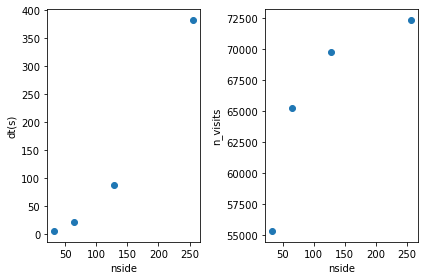

In [50]:
# plot the increase in runtime with n_side
# also the change in counts of visits as nside changes
# as healpix size is reduced, the generation of partial templates means more visits can be used

x_plot = "nside"
y_plot1 = "dt(s)"
y_plot2 = "n_visits"
df_plot = df_nside_test

fig = plt.figure()
gs = gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])

ax1.scatter(df_plot[x_plot],df_plot[y_plot1])
ax2.scatter(df_plot[x_plot],df_plot[y_plot2])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot1)
ax2.set_xlabel(x_plot)
ax2.set_ylabel(y_plot2)

plt.tight_layout()

plt.show()

NEED TO DIVIDE data INTO CHUNKS OF THE CORRECT TIMESCALE (template_timescale).

If Peter's code considers template generation on a single night, we can pass visits to it in growing chunks based on the dates when we want to consider template generation.

Pass all visits with night <= t + template_timescale so that all previous observations will count towards making templates

In [51]:
template_timescale = 28*4 # generate templates every 4 weeks
template_nights = np.arange(0,365+template_timescale,template_timescale)
template_nights

array([  0, 112, 224, 336, 448])

In [52]:
# Make runtime estimates for all 
nside_list = [32,64,128,256]

# tscales = [1,7,14,28,28*2,28*3,28*4,28*6]
tscales = [28,28*4,28*6]
# tscales = [28*4]

# nside = 256
# nside = 32

for _nside in nside_list:
    dt = df_nside_test[df_nside_test["nside"]==_nside].iloc[0]["dt(s)"]

    print("nside = {}, dt(1 step) = {} s".format(_nside,dt))

    t_tot = 0
    for template_timescale in tscales:

        template_nights = np.arange(template_timescale,365+template_timescale,template_timescale)
        template_nights[-1] = 365 # consider only the first year

        t_est = dt * len(template_nights)
        t_tot += t_est
        print(template_timescale,len(template_nights),t_est/60/60) # print time estimate in hours for each template timescale

    print("t_tot = {:.2f} min ({:2f} hrs)".format(t_tot/60,t_tot/60/60))


nside = 32, dt(1 step) = 5.473571062088013 s
28 14 0.02128610968589783
112 4 0.006081745624542236
168 3 0.004561309218406678
t_tot = 1.92 min (0.031929 hrs)
nside = 64, dt(1 step) = 21.456645965576172 s
28 14 0.08344251208835178
112 4 0.023840717739529078
168 3 0.01788053830464681
t_tot = 7.51 min (0.125164 hrs)
nside = 128, dt(1 step) = 88.28198504447937 s
28 14 0.3433188307285309
112 4 0.09809109449386597
168 3 0.07356832087039947
t_tot = 30.90 min (0.514978 hrs)
nside = 256, dt(1 step) = 383.25205516815186 s
28 14 1.4904246589872574
112 4 0.425835616853502
168 3 0.31937671264012657
t_tot = 134.14 min (2.235637 hrs)


# Run the full remove template code on all date ranges

In [62]:
start = time.time()

# nside = 32
nside = 256

template_visits = {}
for template_timescale in tscales:
    
    n_visits = []
    obsIds = []
    
    # divide year 1 into chunks of a given template_timescale
#     template_nights = np.arange(template_timescale,365+template_timescale,template_timescale)
    template_nights = np.arange(0,365+template_timescale,template_timescale)
    template_nights[-1] = 365 # consider only the first year
    
    for i in range(1,len(template_nights)):
        t = template_nights[i]
        # select visits in chunk from original year 1 database
        data = maf.getSimData(opsdb, None, None,
                              full_sql_query='select * from observations where night <= {};'.format(t))
        # remove templates without visits
#         data_w_templates = remove_no_templates(data, night_template_min = template_timescale, nside = nside)
        data_w_templates = remove_no_templates(data, night_template_min = template_nights[i-1], nside = nside)
        n = data_w_templates.size
        n_visits.append(n)
        obsIds += list(data_w_templates["observationId"])
        print(t,n,data.size,len(obsIds))
    
    # get the ids of each observation that has a template and can be kept
#     obsIds = data_w_templates["observationId"]
    # store the obsids of each timescale
    template_visits[template_timescale] = {"n_visits":n_visits,
                                          "template_nights":template_nights[1:],
                                          "obsIds":obsIds}
#     break

end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

night_template_min = 0
28 0 20633 0
night_template_min = 28
56 8506 36010 8506
night_template_min = 56
84 12916 55182 21422
night_template_min = 84
112 11552 72112 32974
night_template_min = 112
140 15272 92419 48246
night_template_min = 140
168 14593 111987 62839
night_template_min = 168
196 18500 135164 81339
night_template_min = 196
224 20571 159169 101910
night_template_min = 224
252 6601 166678 108511
night_template_min = 252
280 11648 179588 120159
night_template_min = 280
308 9388 189807 129547
night_template_min = 308
336 11944 202010 141491
night_template_min = 336
364 13527 216120 155018
night_template_min = 364
365 258 216378 155276
night_template_min = 0
112 0 72112 0
night_template_min = 112
224 47828 159169 47828
night_template_min = 224
336 37678 202010 85506
night_template_min = 336
365 13775 216378 99281
night_template_min = 0
168 0 111987 0
night_template_min = 168
336 63374 202010 63374
night_template_min = 336
365 13775 216378 77149
6091.7975969314575s (101.529960mi

In [63]:
template_visits[template_timescale]

{'n_visits': [0, 63374, 13775],
 'template_nights': array([168, 336, 365]),
 'obsIds': [111987,
  111988,
  111989,
  111990,
  111991,
  111992,
  111993,
  111994,
  111995,
  111996,
  111997,
  111998,
  111999,
  112000,
  112001,
  112002,
  112003,
  112004,
  112005,
  112006,
  112007,
  112008,
  112009,
  112010,
  112011,
  112012,
  112013,
  112014,
  112015,
  112016,
  112017,
  112018,
  112019,
  112020,
  112021,
  112022,
  112023,
  112024,
  112025,
  112026,
  112027,
  112028,
  112029,
  112030,
  112031,
  112032,
  112033,
  112034,
  112035,
  112036,
  112037,
  112038,
  112039,
  112040,
  112041,
  112042,
  112043,
  112044,
  112045,
  112046,
  112047,
  112048,
  112049,
  112050,
  112051,
  112052,
  112053,
  112054,
  112055,
  112056,
  112057,
  112058,
  112059,
  112060,
  112061,
  112062,
  112063,
  112064,
  112065,
  112066,
  112067,
  112068,
  112069,
  112070,
  112071,
  112072,
  112073,
  112074,
  112075,
  112076,
  112077,
  11

In [64]:
# save each the redacted database for each timescale
df_data = pd.DataFrame(data)
print(len(df_data))

for template_timescale in tscales:
    
    df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[template_timescale]["obsIds"])]
    print(template_timescale, len(df_data_w_templates))
    
    fname = "visit_cut_t-{}d_nside-{}.db".format(template_timescale,nside)
    print(fname)

    # open up a connection to a new database
    conn = sqlite3.connect(fname)
    # save reduced visit dataframe to sql
    df_data_w_templates.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()

216378
28 155276
visit_cut_t-28d_nside-256.db
112 99281
visit_cut_t-112d_nside-256.db
168 77149
visit_cut_t-168d_nside-256.db


In [65]:
# select a timescale to analyse
template_timescale = 28
# template_timescale = 112
# template_timescale = 168

df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[template_timescale]["obsIds"])]

In [66]:
sys.getsizeof(df_data_w_templates)

73015606

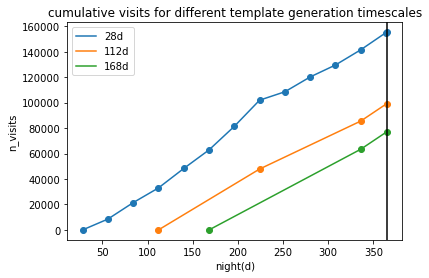

In [67]:
# plot the (cumulative) number of visits with templates as a function of survey night
# different lines show the effect of generating templates on different timescales

x_plot = "night(d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

for t in tscales:
#     ax1.plot(template_visits[t]["template_nights"], template_visits[t]["n_visits"], label = "{}d".format(t))
#     ax1.scatter(template_visits[t]["template_nights"], template_visits[t]["n_visits"])
    ax1.plot(template_visits[t]["template_nights"], np.array(template_visits[t]["n_visits"]).cumsum(), label = "{}d".format(t))
    ax1.scatter(template_visits[t]["template_nights"], np.array(template_visits[t]["n_visits"]).cumsum())

ax1.legend()
ax1.axvline(365,c="k")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.title("cumulative visits for different template generation timescales")

plt.show()

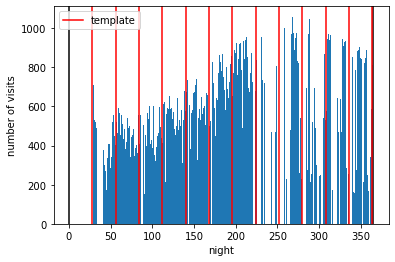

In [68]:
# distribution of visits with templates by night

x_plot = "night"
df_plot = df_data_w_templates
bins = np.arange(0,366,1)

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.hist(df_plot[x_plot],bins=bins)

ax1.axvline(0,c="k")
ax1.axvline(365,c="k")

for t in np.arange(template_timescale,365+template_timescale,template_timescale):
    if t>365:
        continue
    ax1.axvline(t,c="r", label = "template")

ax1.set_xlabel(x_plot)
ax1.set_ylabel("number of visits")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

plt.show()

In [69]:
for t in tscales:
    print(t, template_visits[t]["n_visits"][-1])

28 258
112 13775
168 13775


NameError: name 'template_times' is not defined

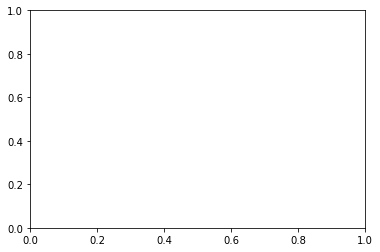

In [70]:
# plot number of visits vs template timescale
    
x_plot = "template creation timescale (d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(template_times, [template_visits[t]["n_visits"][-1] for t in template_times])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

# run some metrics on the reduced dataset

In [ ]:
nside = 256
template_timescale = 28
fname = "visit_cut_t-{}d_nside-{}.db".format(template_timescale,nside)

In [ ]:
nside,fname

In [ ]:
opsim = fname
metric = maf.metrics.CountMetric(col='observationStartMJD', metricName='Nvisits')
slicer = maf.slicers.HealpixSlicer(nside=nside)
constraint = None

In [ ]:
outDir = 'temp_nvisits' # where to output plots and things generated by the MAF analysis
bundle = maf.MetricBundle(metric, slicer, constraint, runName=opsim)
g = maf.MetricBundleGroup({'nvisits': bundle}, opsim, outDir=outDir)
g.runAll()

In [ ]:
plt.figure()
bundle.plot()

In [ ]:
nside = 32
# nside = 256
nside_file = 256
template_timescale = 28
opsim = "visit_cut_t-{}d_nside-{}.db".format(template_timescale,nside_file)

metric = maf.metrics.CountMetric(col='observationStartMJD', metricName='Nvisits')
slicer = maf.slicers.HealpixSlicer(nside=nside)
constraint = None

for filt in ["g","r","i"]:
    constraint = 'filter=="{}"'.format(filt)
    
    outDir = 'temp_nvisits' # where to output plots and things generated by the MAF analysis
    bundle = maf.MetricBundle(metric, slicer, constraint, runName=opsim)
    g = maf.MetricBundleGroup({'nvisits': bundle}, opsim, outDir=outDir)
    g.runAll()
    
    plt.figure()
    bundle.plot()

In [ ]:
# also run the solar system metrics, and pairMetric to analyse filter pairs for which there are templates

In [ ]:
metric = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName='Pairs')
nside = 32
# nside = 256
slicer = maf.slicers.HealpixSlicer(nside=nside)
# constraint = None
constraint = 'filter=="g"'

In [ ]:
nside = 32
nside_file = 256
template_timescale = 168
opsim = "visit_cut_t-{}d_nside-{}.db".format(template_timescale,nside_file)

for constraint in ['filter=="g" or filter=="r" or filter=="i"']:
    print(opsim,constraint)
    outDir = 'temp_nvisits' # where to output plots and things generated by the MAF analysis
    bundle = maf.MetricBundle(metric, slicer, constraint, runName=opsim)
    g = maf.MetricBundleGroup({'Pairs': bundle}, opsim, outDir=outDir)
    g.runAll()

    plt.figure()
    plotDict = {'colorMin': 0, 'colorMax': 25}
    bundle.setPlotDict(plotDict)
    bundle.plot()

In [ ]:
opsim = "first_year_baseline_v3.0_10yrs.db"
for constraint in ['filter=="g" or filter=="r" or filter=="i"']:
    print(opsim,constraint)
    outDir = 'temp_nvisits' # where to output plots and things generated by the MAF analysis
    bundle = maf.MetricBundle(metric, slicer, constraint, runName=opsim)
    g = maf.MetricBundleGroup({'Pairs': bundle}, opsim, outDir=outDir)
    g.runAll()

    plt.figure()
    plotDict = {'colorMin': 0, 'colorMax': 25}
    bundle.setPlotDict(plotDict)
    bundle.plot()

In [ ]:
nside_file = 256
nside = 32
constraint = 'filter=="g"'

bundles = []
bundle_names = []
for template_timescale in [28,112,168]:
    
    opsim = "visit_cut_t-{}d_nside-{}.db".format(template_timescale,nside_file)
    
    print(opsim,constraint)
    outDir = 'temp_nvisits' # where to output plots and things generated by the MAF analysis
    bundle = maf.MetricBundle(metric, slicer, constraint, runName=opsim)
    g = maf.MetricBundleGroup({'Pairs': bundle}, opsim, outDir=outDir)
    g.runAll()
    
    bundles.append(bundle)
    bundle_names.append(opsim)
    
    plt.figure()
    bundle.plot()
    
    


In [ ]:
bundles

In [ ]:
example2_ph = maf.PlotHandler()

example2_ph.setMetricBundles(bundles)

plot_dicts = [
    {"label": bundle_names[0], "color": "C0"},
    {"label": bundle_names[1], "color": "C1"},
    {"label": bundle_names[2], "color": "C2"}
]

example2_ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts = plot_dicts)

In [ ]:
bundles[0].metricValues

In [ ]:
len(bundles[0].metricValues)

In [ ]:
bundles[0].slicer.slicePoints

In [ ]:
len(bundles[0].slicer.slicePoints["sid"])

In [ ]:
nside,hp.pixelfunc.nside2resol(nside, arcmin=True)

In [ ]:
nside,hp.pixelfunc.nside2pixarea(nside, degrees=True)

In [ ]:
np.histogram()

In [ ]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

for i in range(len(bundles)):
    data = bundles[i].metricValues
    data = data[~data.mask]
#     ax1.hist(data,label = bundle_names[i])

    bins = np.arange(0, data.max() + 1.5) - 0.5
#     ax1.hist(data,bins,label = bundle_names[i])
    hist, bins = np.histogram(data,bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.bar(center, hist, align='center', width=width, alpha = 0.3)
    
#     ax1.scatter(center, hist, label = bundle_names[i])

# scale the y axis to get sky area
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees
y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])

ax1.set_xlabel("pairs")
ax1.set_ylabel("area (square degrees)")

ax1.set_yscale("log")

ax1.legend()

plt.show()

In [ ]:
# try plot a manual healpix map. I've done this before?

In [ ]:
fig = plt.figure()

# hp.visufunc.mollview(map = bundles[0].metricValues - bundles[2].metricValues)
hp.visufunc.mollview(map = bundles[0].metricValues)
hp.visufunc.graticule()

plt.show()

In [ ]:
b.plot.__code__.co_varnames

In [ ]:
# compare pairs for different timescales
constraint = 'filter=="g" or filter=="r" or filter=="i"'

nside_file = 256
nside = 32

bundle_list = []
bundle_name_list = []
for template_timescale in [28,112,168]:
    
    opsim = "visit_cut_t-{}d_nside-{}.db".format(template_timescale,nside_file)
    print(opsim,constraint)
    outDir = 'temp_pairs' # where to output plots and things generated by the MAF analysis
    bundle = maf.MetricBundle(metric, slicer, constraint, runName=opsim)
    
    bundle_list.append(bundle)
    bundle_name_list.append("pairs {}d".format(template_timescale))
    
g = maf.MetricBundleGroup(dict(zip(bundle_name_list, bundle_list)), otherdb, outDir=outDir)
# g.runAll()